---
# Anomaly Detection Project
---

## Imports
---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import env

import acquire as a
import prepare as p

# plotting settings
plt.rc('font', size=12)
plt.rc('figure', figsize=(15, 7))
pd.options.display.float_format = '{:.2f}'.format
sns.set_palette('colorblind')

---
## Acquire
---

In [2]:
# lets get the data
df = a.get_log_data()

In [3]:
df.head()

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
0,2018-01-26,09:55:03,/,1,8.00,97.105.19.61,8.00,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.00
1,2018-01-26,09:56:02,java-ii,1,8.00,97.105.19.61,8.00,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.00
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.00,97.105.19.61,8.00,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.00
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.00,97.105.19.61,8.00,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.00
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.00,97.105.19.61,22.00,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,NaN,2.00


In [4]:
df.shape

(900223, 15)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900223 entries, 0 to 900222
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        900223 non-null  object 
 1   time        900223 non-null  object 
 2   path        900222 non-null  object 
 3   user_id     900223 non-null  int64  
 4   cohort_id   847330 non-null  float64
 5   ip          900223 non-null  object 
 6   id          847330 non-null  float64
 7   name        847330 non-null  object 
 8   slack       847330 non-null  object 
 9   start_date  847330 non-null  object 
 10  end_date    847330 non-null  object 
 11  created_at  847330 non-null  object 
 12  updated_at  847330 non-null  object 
 13  deleted_at  0 non-null       float64
 14  program_id  847330 non-null  float64
dtypes: float64(4), int64(1), object(10)
memory usage: 109.9+ MB


Initial Observations:
- None of the dates are in datetime format, that needs to be corrected
    - `date`, `time`, `start_date`, `end_date`, `created_at`, `updated_at`
- The date of access needs to become index column, but I need to figure out how to merge the date and time columns info a single datetime index
- The path column needs to be split out into several columns for future use 
    - Use Zach's function to do this and just make necessary changes for this path format
- `user_id` is the unique identifier for each student
- `cohort_id` and `id` should be the same since that is what I joined on and there should be some nulls somewhere since inner and left join produced different results
    - Take a look at this before dropping one of the columns just to see what's going on
    - These columns are currently both floats, so for whichever I decide to keep, I will most likely convert to integer
- `ip` seems to be able to be left as-is
    - Just need to be careful with this potentially sensitive data
- `name` seems to be good as-is
- `slack` not sure if this will be useful
- `start_date` and `end_date` will allow us to determine if people are accessing the curriculum after they finish and what they are accessing
    - If students are accessing curriculum before their start date, this is an issue since they shouldn't have access until they are granted access through github on the first week or so of class
- `created_at` and `updated_at` columns seem to be just when the entry was created for the cohort identification table
    - Probably won't be super useful
    - Can see if any have been updated since dates seem to be mostly the same
- `deleted_at`
    - See if any were deleted
    - If they were, I would wonder why
- `program_id'
    - This could be mapped to name of program
        - Data Science, Web Dev, and then I would need to ask instructors what any other categories might mean
        - 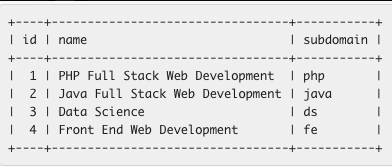

---
## Prepare/Get to know data
---

### `date` and `time`

In [6]:
# add them together as strings
df['date'] = df.date + ' ' + df.time

In [7]:
# and then convert to datetime
df.date = pd.to_datetime(df.date)

In [8]:
# then covert this into index
df = df.set_index(df.date)

In [9]:
# drop columns that have been converted to index
df = df.drop(columns=['date', 'time'])

---
### `path`

In [10]:
df.tail(5)

,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
date,,,,,,,,,,,,,
2021-04-21 16:41:51,jquery/personal-site,64,28.00,71.150.217.33,28.00,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,NaN,2.00
2021-04-21 16:42:02,jquery/mapbox-api,64,28.00,71.150.217.33,28.00,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,NaN,2.00
2021-04-21 16:42:09,jquery/ajax/weather-map,64,28.00,71.150.217.33,28.00,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,NaN,2.00
2021-04-21 16:44:37,anomaly-detection/discrete-probabilistic-methods,744,28.00,24.160.137.86,28.00,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,NaN,2.00
2021-04-21 16:44:39,jquery/mapbox-api,64,28.00,71.150.217.33,28.00,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,NaN,2.00


- Looks like most paths only have 2 parts, the section and the specific page
- I do see some with 1 and 3 though
- Is it even necessary to split up the path?
    - Each current path points to a lesson, so it should be fine as-is
- If I wanted to look at modules instead of lessons, I might need to split it out
    - I will tackle that if I have enough time at the end

In [11]:
# # my first draft of a function to parse this thing
# def parse_path(entry):
#     parts = entry.split('/')
#     output = {}
#     output['module'] = parts[0]
#     output['lesson'] = parts[1]
#     if len(parts) > 2:
#         output['section'] = parts[1:]
#     return pd.Series(output)
# # this won't work in it's current state because some entries only have 1 item in the list
# # would need to either do some cleaning first or add more if statements

In [12]:
# find most commonly accessed part of the curriculum accross all cohorts
df.path.value_counts().head(30)

/                                                                            50313
search/search_index.json                                                     19519
javascript-i                                                                 18983
toc                                                                          18297
java-iii                                                                     13733
html-css                                                                     13635
java-ii                                                                      12685
spring                                                                       12524
jquery                                                                       11525
mysql                                                                        11033
java-i                                                                       10865
javascript-ii                                                                10730
appe

In [13]:
# lets just assume that first entry is module and second is lesson
# df['module'] = df.path.str.split('/').str[0]
# df['lesson'] = df.path.str.split('/').str[1]
# this works except you can't tell which module each lesson is in
# will be better to pull them apart and then put them back together only including first 2 parts of path so that each lesson is unique 
# even if different modules have lessons with same name

In [14]:
df['module/lesson'] = df.path.str.split('/').str[0] + '/' + df.path.str.split('/').str[1]

---
### `user_id`

In [15]:
df.user_id.nunique()

981

In [16]:
# could do the same thing using value counts
df.user_id.value_counts().head(20)

11     17913
64     16347
53     12329
314     7783
1       7404
495     6451
581     6434
428     5897
344     5460
248     5075
570     4584
315     4510
211     4227
423     3804
555     3687
545     3528
685     3522
524     3512
485     3268
671     3241
Name: user_id, dtype: int64

- 981 unique users in this data, numbered from 1 to 981
- Can easily see who is accessing the most using value counts
    - Once `end_date` column is fixed, we can use the datetimes to filter data to only those who are accessing after graduation

---
### `cohort_id` and `id`

In [17]:
df.cohort_id.nunique()

47

In [18]:
df.name.nunique()

47

In [19]:
df[df.cohort_id != df.id]

,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id,module/lesson
date,,,,,,,,,,,,,,
2018-01-26 16:46:16,/,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/
2018-01-26 16:46:24,spring/extra-features/form-validation,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,spring/extra-features
2018-01-26 17:54:24,/,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/
2018-01-26 18:32:03,/,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/
2018-01-26 18:32:17,mysql/relationships/joins,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mysql/relationships
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21 12:49:00,javascript-ii,717,NaN,136.50.102.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-21 12:49:02,javascript-ii/es6,717,NaN,136.50.102.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,javascript-ii/es6
2021-04-21 12:51:27,javascript-ii/map-filter-reduce,717,NaN,136.50.102.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,javascript-ii/map-filter-reduce


- Looks like there are 52,893 rows in the original data where there was no cohort_id to join on
    - These rows will be useful for overall analysis, but will not be helpful when looking at things on a cohort-level

In [20]:
df[df.cohort_id.isna() == True]

,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id,module/lesson
date,,,,,,,,,,,,,,
2018-01-26 16:46:16,/,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/
2018-01-26 16:46:24,spring/extra-features/form-validation,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,spring/extra-features
2018-01-26 17:54:24,/,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/
2018-01-26 18:32:03,/,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/
2018-01-26 18:32:17,mysql/relationships/joins,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mysql/relationships
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21 12:49:00,javascript-ii,717,NaN,136.50.102.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-21 12:49:02,javascript-ii/es6,717,NaN,136.50.102.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,javascript-ii/es6
2021-04-21 12:51:27,javascript-ii/map-filter-reduce,717,NaN,136.50.102.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,javascript-ii/map-filter-reduce


In [21]:
df[df.id.isna() == True]

,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id,module/lesson
date,,,,,,,,,,,,,,
2018-01-26 16:46:16,/,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/
2018-01-26 16:46:24,spring/extra-features/form-validation,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,spring/extra-features
2018-01-26 17:54:24,/,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/
2018-01-26 18:32:03,/,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/
2018-01-26 18:32:17,mysql/relationships/joins,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mysql/relationships
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21 12:49:00,javascript-ii,717,NaN,136.50.102.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-21 12:49:02,javascript-ii/es6,717,NaN,136.50.102.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,javascript-ii/es6
2021-04-21 12:51:27,javascript-ii/map-filter-reduce,717,NaN,136.50.102.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,javascript-ii/map-filter-reduce


In [22]:
# let's drop the id column since these two columns look identical
df = df.drop(columns='id')

In [23]:
# we can also drop the cohort_id column since they are all mapped to names at this point via the merge
df = df.drop(columns='cohort_id')

---
### `ip`

In [24]:
df.ip.value_counts().head(10)

97.105.19.58       284579
97.105.19.61        61662
192.171.117.210      9515
71.150.217.33        6791
76.185.145.231       4754
12.106.208.194       4360
67.11.50.23          4181
70.112.179.142       4117
70.121.183.95        3843
172.124.67.93        3511
Name: ip, dtype: int64

- 5531 different ip addresses
- Top 2 look like they must be associated with Codeup campus

In [25]:
df.ip.isnull().sum()

0

---
### `name`

In [26]:
df.name.value_counts()

Staff         84031
Ceres         40730
Zion          38096
Jupiter       37109
Fortuna       36902
Voyageurs     35636
Ganymede      33844
Apex          33568
Deimos        32888
Darden        32015
Teddy         30926
Hyperion      29855
Betelgeuse    29356
Ulysses       28534
Europa        28033
Xanadu        27749
Bayes         26538
Wrangell      25586
Andromeda     25359
Kalypso       23691
Curie         21582
Yosemite      20743
Bash          17713
Luna          16623
Marco         16397
Easley        14715
Lassen         9587
Arches         8890
Florence       8562
Sequoia        7444
Neptune        7276
Olympic        4954
Kings          2845
Pinnacles      2158
Hampton        1712
Oberon         1672
Quincy         1237
Niagara         755
Mammoth         691
Glacier         598
Joshua          302
Ike             253
Badlands         93
Franklin         72
Apollo            5
Denali            4
Everglades        1
Name: name, dtype: int64

- Nothing much to take away here
- Null are those without `cohort_id`

---
### `slack`

In [27]:
df.slack.nunique()

46

In [28]:
df.name.nunique()

47

In [29]:
df.slack.unique()

array(['#hampton', '#teddy', '#sequoia', '#arches', '#niagara',
       '#pinnacles', '#quincy', nan, '#kings', '#lassen', '#mammoth',
       '#glacier', '#denali', '#joshua', '#olympic', '#ulysses',
       '#badlands', '#apollo', '#ike', '#voyageurs', '#wrangell',
       '#xanadu', '#franklin', '#yosemite', '#', '#zion', '#andromeda',
       '#betelgeuse', '#ceres', '#deimos', '#europa', '#fortuna',
       '#curie', '#apex', '#ganymede', '#everglades', '#hyperion',
       '#darden', '#bash', '#jupiter', '#kalypso', '#luna', '#easley',
       '#marco', '#neptune', '#florence', '#oberon'], dtype=object)

In [30]:
df.name.unique()

array(['Hampton', 'Teddy', 'Sequoia', 'Arches', 'Niagara', 'Pinnacles',
       'Quincy', nan, 'Kings', 'Lassen', 'Mammoth', 'Glacier', 'Denali',
       'Joshua', 'Olympic', 'Ulysses', 'Badlands', 'Apollo', 'Ike',
       'Voyageurs', 'Wrangell', 'Xanadu', 'Franklin', 'Yosemite', 'Staff',
       'Zion', 'Andromeda', 'Betelgeuse', 'Ceres', 'Bayes', 'Deimos',
       'Europa', 'Fortuna', 'Curie', 'Apex', 'Ganymede', 'Everglades',
       'Hyperion', 'Darden', 'Bash', 'Jupiter', 'Kalypso', 'Luna',
       'Easley', 'Marco', 'Neptune', 'Florence', 'Oberon'], dtype=object)

- Looks like there is one more cohort than there are slack channels
    - The Bayes cohort appears to have used the `#` slack channel (the same one the instructor's use?)

In [31]:
# we can drop this one as I don't think it will be too useful for our purposes here
df = df.drop(columns='slack')

---
### `start_date` and `end_date`

In [32]:
# convert to datetime
df.start_date = pd.to_datetime(df.start_date)
df.end_date = pd.to_datetime(df.end_date)

In [33]:
df.start_date.min()

Timestamp('2014-02-04 00:00:00')

In [34]:
df.start_date.max()

Timestamp('2021-04-12 00:00:00')

In [35]:
df.end_date.min()

Timestamp('2014-02-04 00:00:00')

In [36]:
df.end_date.max()

Timestamp('2021-10-01 00:00:00')

- these columns will be useful when comparing activity to time in program

---
### `created_at` and `updated_at`

In [37]:
# convert to datetime
df.created_at = pd.to_datetime(df.created_at)
df.updated_at = pd.to_datetime(df.updated_at)

In [38]:
df[(df.created_at != df.updated_at) & (df.name.isna() == False)].groupby('name').path.count()

name
Apex       33568
Bash       17713
Niagara      755
Name: path, dtype: int64

- Most cohort info was not ever updated, but 3 cohorts were updated for one reason or another
    - Why were these the only three that were updated? What exactly was updated?

---
### `deleted_at`

In [39]:
df.deleted_at.value_counts()

Series([], Name: deleted_at, dtype: int64)

In [40]:
df.deleted_at.isna().sum()

900223

In [41]:
df.shape

(900223, 11)

- All are empty, can be dropped

In [42]:
df = df.drop(columns='deleted_at')

In [43]:
df.head()

,path,user_id,ip,name,start_date,end_date,created_at,updated_at,program_id,module/lesson
date,,,,,,,,,,
2018-01-26 09:55:03,/,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.00,/
2018-01-26 09:56:02,java-ii,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.00,NaN
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.00,java-ii/object-oriented-programming
2018-01-26 09:56:06,slides/object_oriented_programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.00,slides/object_oriented_programming
2018-01-26 09:56:24,javascript-i/conditionals,2,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2.00,javascript-i/conditionals


---
### `program_id`

In [44]:
df.program_id.value_counts()

2.00    713365
3.00    103412
1.00     30548
4.00         5
Name: program_id, dtype: int64

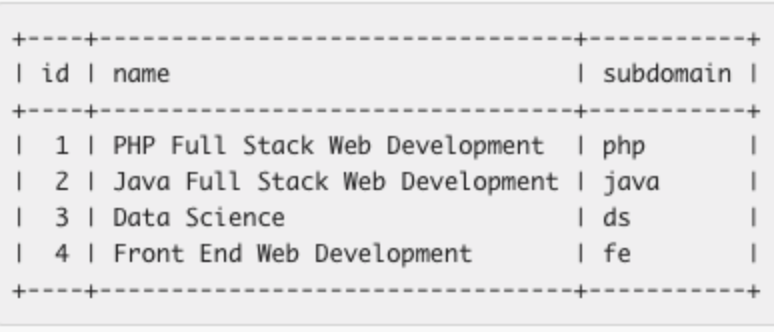

In [45]:
# let's try using mapping and a dictionary instead
program_dict = {
    1 : 'Web Dev - PHP',
    2 : 'Web Dev - Java',
    3 : 'Data Science',
    4 : 'Web Dev - Front End'
}

In [46]:
df['program'] = df.program_id.map(program_dict)

In [47]:
df.program.value_counts()

Web Dev - Java         713365
Data Science           103412
Web Dev - PHP           30548
Web Dev - Front End         5
Name: program, dtype: int64

In [48]:
# we can now drop the program_id column
df = df.drop(columns='program_id')

### Compile into prepare script

- See `prepare.py` file    

In [49]:
df = a.get_log_data()

In [50]:
df = p.prep_log(df)

In [51]:
df.shape

(900223, 10)

In [52]:
df.head()

,path,user_id,ip,name,start_date,end_date,created_at,updated_at,program,module/lesson
date,,,,,,,,,,
2018-01-26 09:55:03,/,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,Web Dev - PHP,/
2018-01-26 09:56:02,java-ii,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,Web Dev - PHP,NaN
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,Web Dev - PHP,java-ii/object-oriented-programming
2018-01-26 09:56:06,slides/object_oriented_programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,Web Dev - PHP,slides/object_oriented_programming
2018-01-26 09:56:24,javascript-i/conditionals,2,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,Web Dev - Java,javascript-i/conditionals


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 900223 entries, 2018-01-26 09:55:03 to 2021-04-21 16:44:39
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   path           900222 non-null  object        
 1   user_id        900223 non-null  int64         
 2   ip             900223 non-null  object        
 3   name           847330 non-null  object        
 4   start_date     847330 non-null  datetime64[ns]
 5   end_date       847330 non-null  datetime64[ns]
 6   created_at     847330 non-null  datetime64[ns]
 7   updated_at     847330 non-null  datetime64[ns]
 8   program        847330 non-null  object        
 9   module/lesson  731934 non-null  object        
dtypes: datetime64[ns](4), int64(1), object(5)
memory usage: 75.5+ MB


In [54]:
df['module/lesson'].isna().sum()

168289

In [55]:
df['module/lesson'].isna().sum() / df.shape[0]

0.18694145783877994

---
## Answer Questions from Email
---

### 1.

1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?

In [56]:
# For this question, I will create a subset of the df where I am only looking at lesson entries where the final path isn't to a .jpg or .svg
# take a look at initial shape
df.shape

(900223, 10)

In [57]:
# df1 will be used when anwering questions related to lessons
# need to get rid of null value in path
df1 = df[df.path.isna() == False]

# take subset where path doesn't end with jpg
df1 = df1[~df1.path.str.endswith('jpg')]

# take subset where path doesn't end with jpeg
df1 = df1[~df1.path.str.endswith('jpeg')]

# take subset where path doesn't end with svg
df1 = df1[~df1.path.str.endswith('svg')]

# take subset where path doesn't end with png)
df1 = df1[~df1.path.str.endswith('png)')]

# I also want to get rid of requests for the home page or the search feature
df1 = df1[(df1.path != '/') & (df1.path != 'search/search_index.json')]

df1.shape

(811881, 10)

#### All Programs

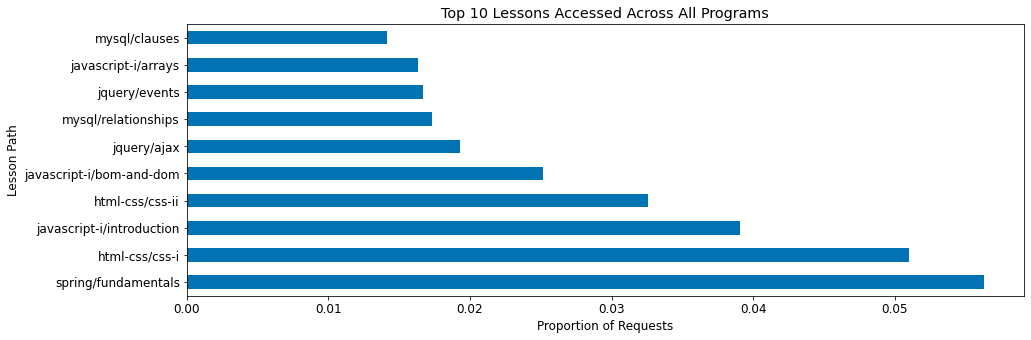

In [58]:
# this is just lessons
df1['module/lesson'].value_counts(normalize=True).head(10).plot.barh(figsize=(15,5))
plt.title('Top 10 Lessons Accessed Across All Programs')
plt.ylabel('Lesson Path')
plt.xlabel('Proportion of Requests');

In [59]:
# # this is paths
# df1.path.value_counts(normalize=True).head(10).plot.barh(figsize=(15,5))
# plt.title('Top 10 Modules Accessed Across All Programs')
# plt.ylabel('Module')
# plt.xlabel('Proportion of Requests');

In [60]:
# now lets do it per program
df1.program.unique()

array(['Web Dev - PHP', 'Web Dev - Java', nan, 'Web Dev - Front End',
       'Data Science'], dtype=object)

In [61]:
php_df = df1[df1.program == 'Web Dev - PHP']
java_df = df1[df1.program == 'Web Dev - Java']
fe_df = df1[df1.program == 'Web Dev - Front End']
ds_df = df1[df1.program == 'Data Science']

#### PHP

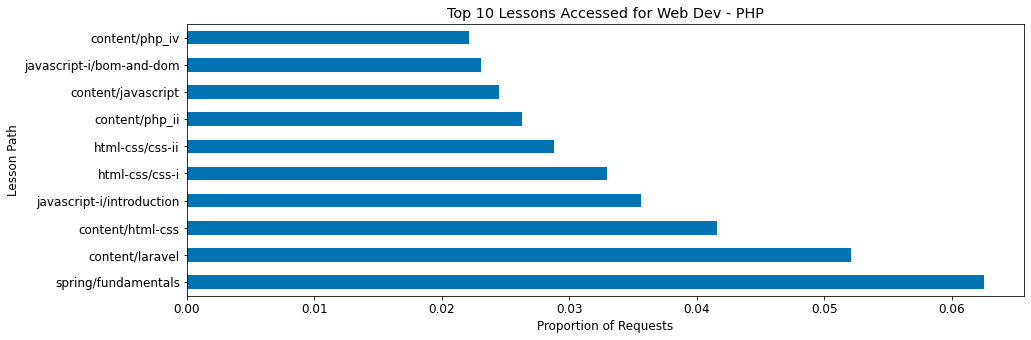

In [62]:
php_df['module/lesson'].value_counts(normalize=True).head(10).plot.barh(figsize=(15,5))
plt.title('Top 10 Lessons Accessed for Web Dev - PHP')
plt.ylabel('Lesson Path')
plt.xlabel('Proportion of Requests');

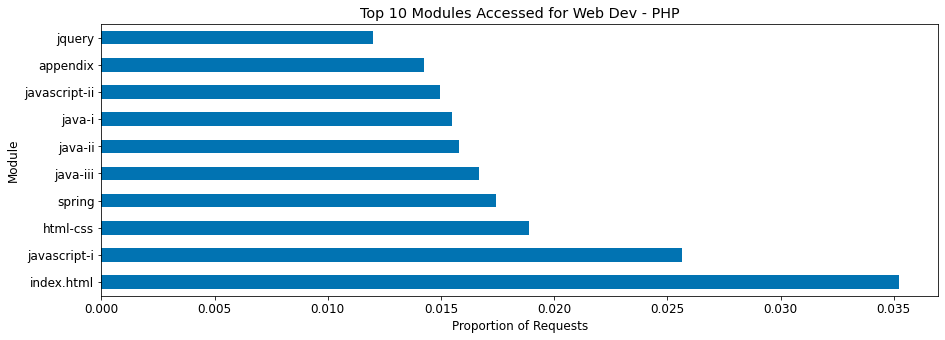

In [63]:
php_df.path.value_counts(normalize=True).head(10).plot.barh(figsize=(15,5))
plt.title('Top 10 Modules Accessed for Web Dev - PHP')
plt.ylabel('Module')
plt.xlabel('Proportion of Requests');

#### Java

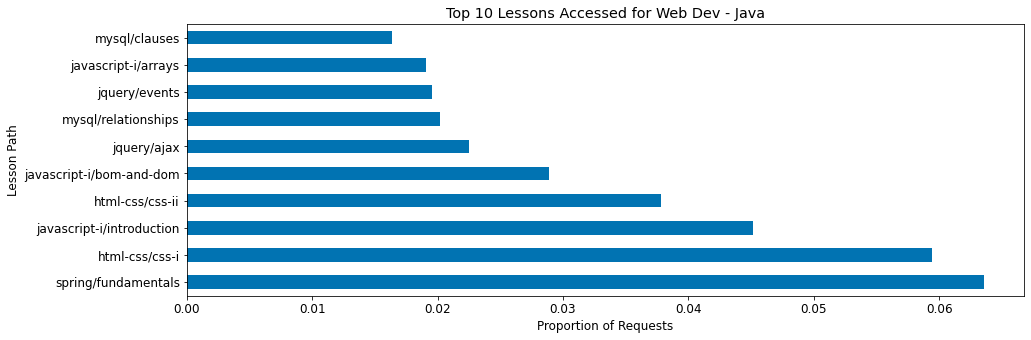

In [64]:
java_df['module/lesson'].value_counts(normalize=True).head(10).plot.barh(figsize=(15,5))
plt.title('Top 10 Lessons Accessed for Web Dev - Java')
plt.ylabel('Lesson Path')
plt.xlabel('Proportion of Requests');

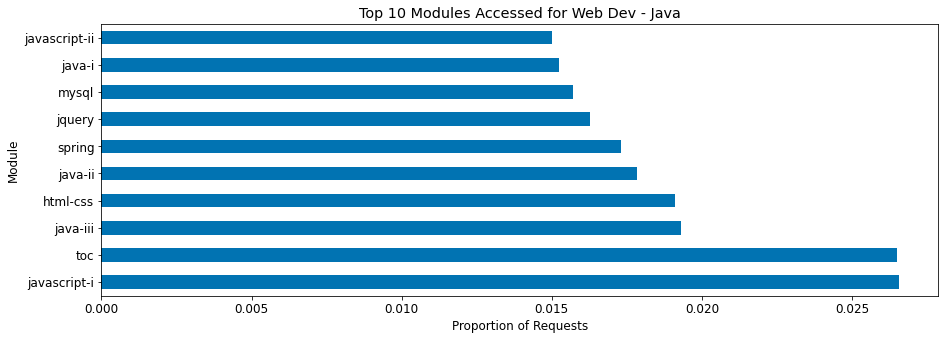

In [65]:
java_df.path.value_counts(normalize=True).head(10).plot.barh(figsize=(15,5))
plt.title('Top 10 Modules Accessed for Web Dev - Java')
plt.ylabel('Module')
plt.xlabel('Proportion of Requests');

#### Front End

In [66]:
# fe_df['module/lesson'].value_counts(normalize=True).head(10).plot.bar(figsize=(15,5))
# plt.title('Top Lessons Accessed for Web Dev - Front End')
# plt.xlabel('Lesson Path')
# plt.ylabel('Proportion of Requests');

**Not really useful, will not include since this program had so few students**

In [67]:
fe_df.shape

(4, 10)

In [68]:
# fe_df.path.value_counts(normalize=True).head(10).plot.bar(figsize=(15,5))
# plt.title('Top 3 Paths Accessed for Web Dev - Front End')
# plt.xlabel('Lesson Path')
# plt.ylabel('Proportion of Requests');

#### Data Science

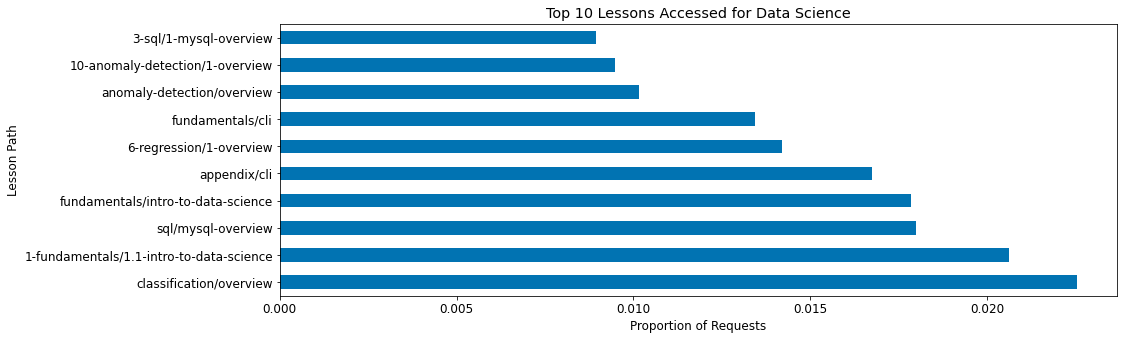

In [69]:
ds_df['module/lesson'].value_counts(normalize=True).head(10).plot.barh(figsize=(15,5))
plt.title('Top 10 Lessons Accessed for Data Science')
plt.ylabel('Lesson Path')
plt.xlabel('Proportion of Requests');

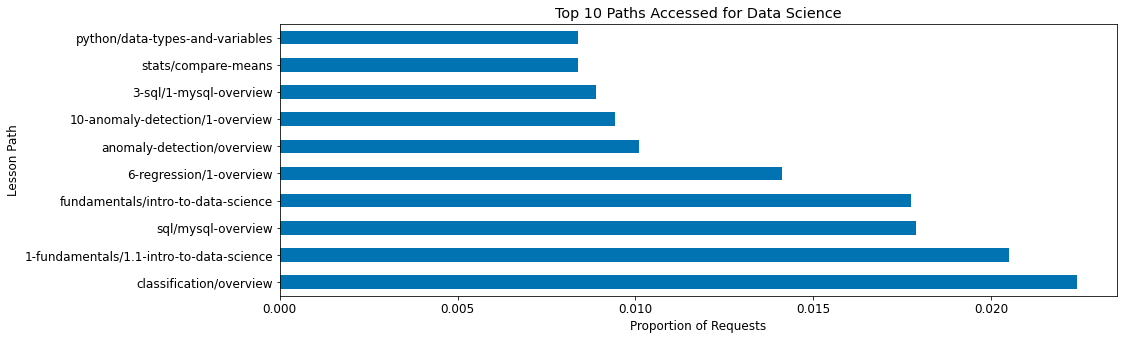

In [70]:
ds_df.path.value_counts(normalize=True).head(10).plot.barh(figsize=(15,5))
plt.title('Top 10 Paths Accessed for Data Science')
plt.ylabel('Lesson Path')
plt.xlabel('Proportion of Requests');

### 2.

2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?

Conditional probability, cohorts given lesson (or vice versa?)

In [71]:
df1.program.value_counts()

Web Dev - Java         657581
Data Science            79611
Web Dev - PHP           28708
Web Dev - Front End         4
Name: program, dtype: int64

#### PHP 

In [72]:
# lets look at this by program, then group by lesson, and get count for each cohort
php1 = php_df.groupby('module/lesson').name.value_counts(normalize=True).sort_values().unstack(0)
php1.head()

module/lesson,1-fundamentals/1.1-intro-to-data-science,1-fundamentals/2.4-more-excel-features,10-anomaly-detection/1-overview,13-advanced-topics/1-tidy-data,2-storytelling/1-overview,2-storytelling/2.1-understand,2-storytelling/2.2-create,2-storytelling/bad-charts,2-storytelling/project,3-sql/database-design,...,spring/fundamentals,spring/security,spring/setup,student/create,students/468,students/units,teams/13,web-design/intro,web-design/ui,web-design/ux
name,,,,,,,,,,,,,,,,,,,,,
Arches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.40,NaN,0.45,NaN,NaN,1.00,NaN,NaN,NaN,NaN
Badlands,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Denali,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Franklin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Glacier,0.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
php1.columns.size

189

In [74]:
php1.index

Index(['Arches', 'Badlands', 'Denali', 'Franklin', 'Glacier', 'Hampton', 'Ike',
       'Joshua', 'Kings', 'Lassen', 'Olympic', 'Quincy'],
      dtype='object', name='name')

Lessons that one cohort looked at more than others:
 - Made sure at least 5 cohorts looked at the lessons since if not, it was likely only available for the cohorts who viewed it
 - One higher and all others below 0.2

In [75]:
# # see if I can plot these
# for col in php1.columns:
#     ax = sns.barplot(x=php1.index, y=php1[col])
#     ax.grid(b=True, which='major', color='black', linewidth=0.075)
#     ax.grid(b=True, which='minor', color='black', linewidth=0.075)
#     plt.show()
#     plt.show()

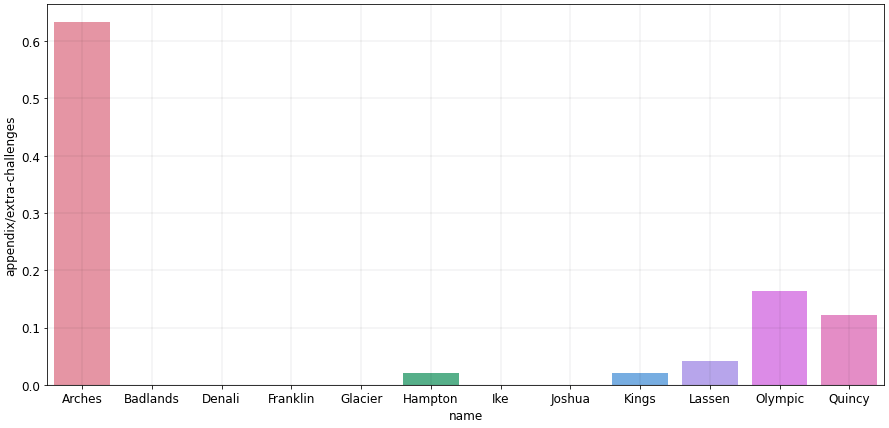
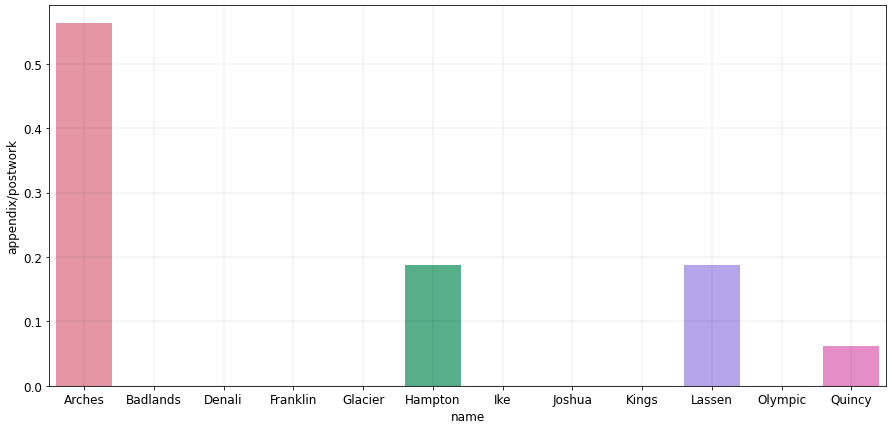
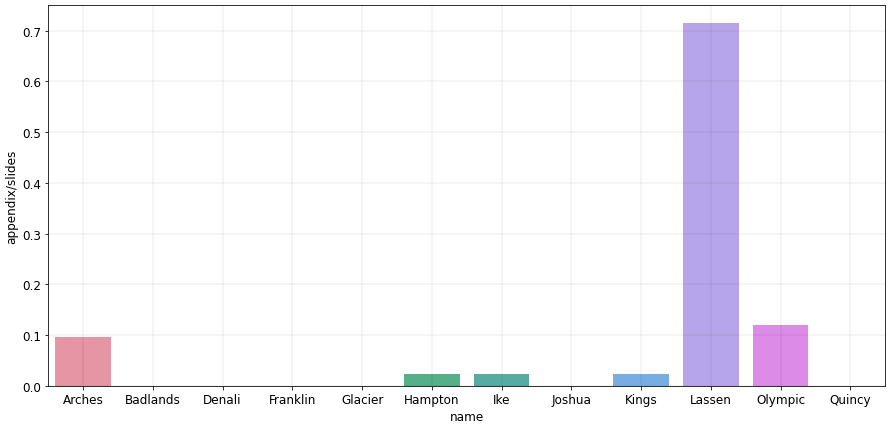
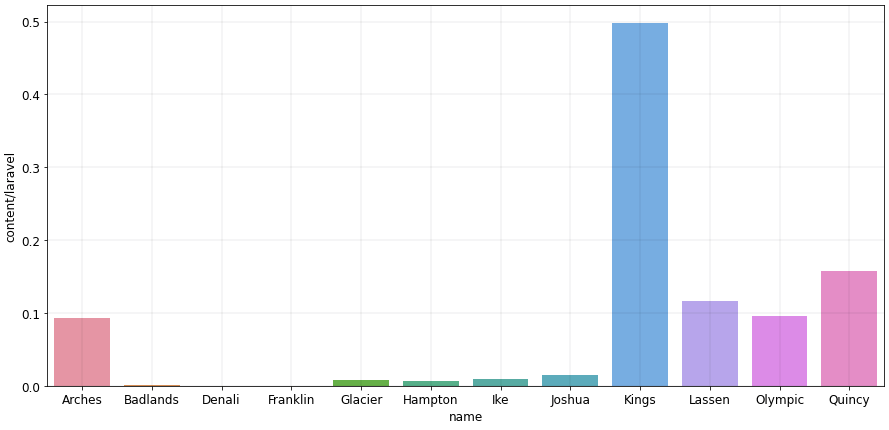
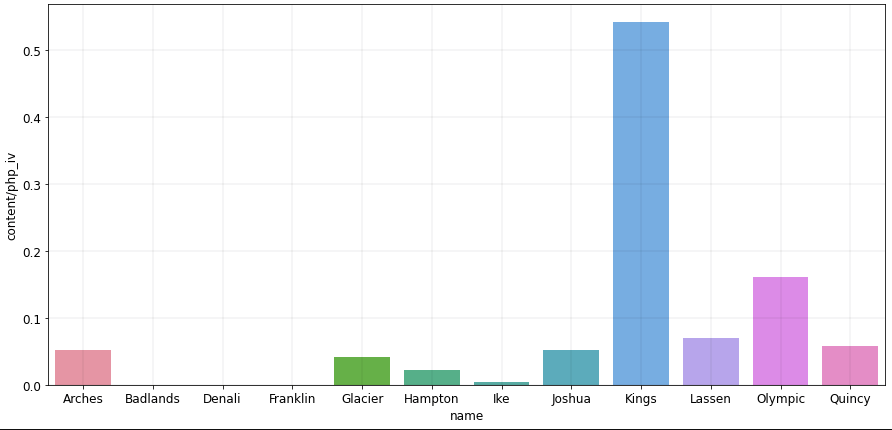
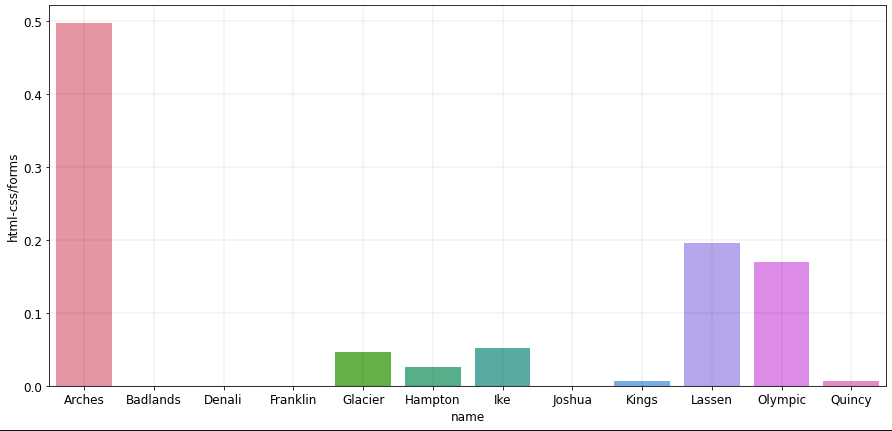
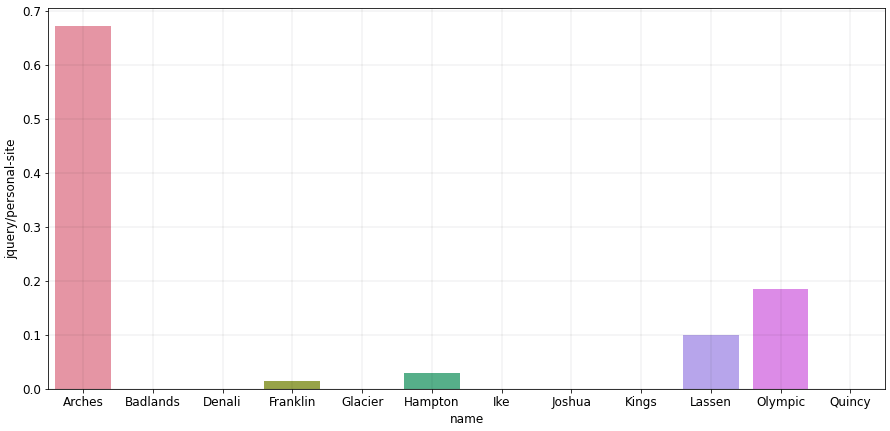
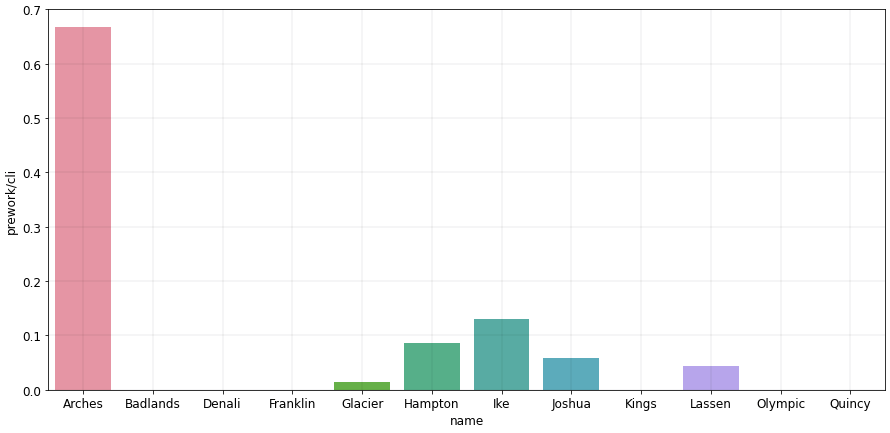
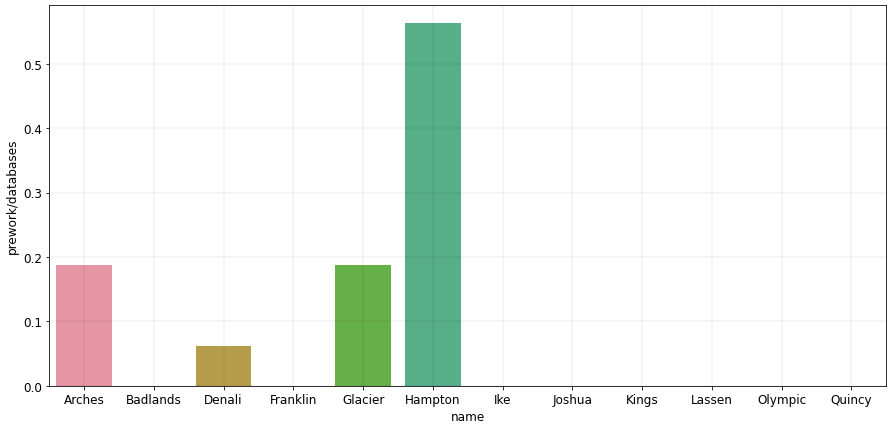
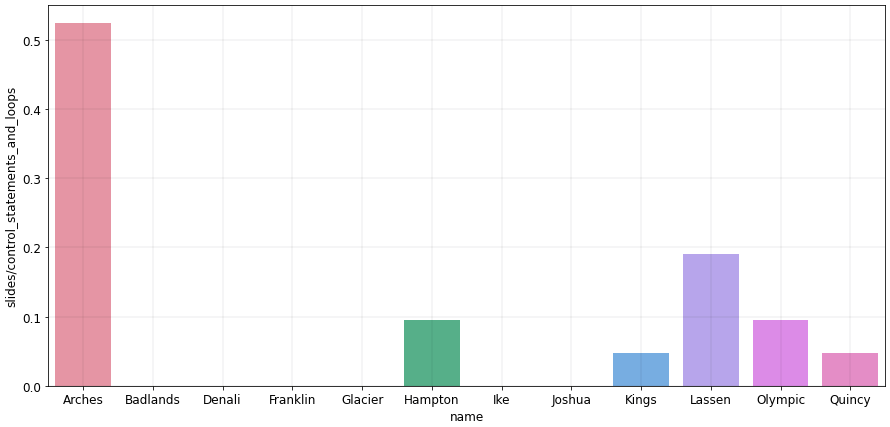

Lessons viewed more by one cohort than others for PHP program:
1. `appendix/extra challenges` - Arches
1. `appendix/postwork` - Arches
1. `appendix/slides` - Lassen
1. `content/laravel` - Kings
1. `content/php_iv` - Kings
1. `html-css/forms`- Arches
1. `jquery/personal-site` - Arches
1. `prework/cli` - Arches
1. `prework/databases` - Hampton
1. `slides/control_statements_and_loops` - Arches

---
#### Java

In [76]:
# lets look at this by program, then group by lesson, and get count for each cohort
java1 = java_df[java_df.name != 'Staff'].groupby('module/lesson').name.value_counts(normalize=True).sort_values().unstack(0)
java1.head()

module/lesson,.well-known/assetlinks.json,1-fundamentals/1-fundamentals-overview,1-fundamentals/1.1-intro-to-data-science,1-fundamentals/1.2-data-science-pipeline,1-fundamentals/1.3-pipeline-demo,1-fundamentals/2.1-intro-to-excel,1-fundamentals/2.2-excel-functions,1-fundamentals/2.3-visualization-with-excel,1-fundamentals/3-vocabulary,1-fundamentals/pipeline-demo,...,student/120,student/202,student/850,students/743,timeline/java-i,tools/codeup,ui/typography,web-design/intro,web-design/ui,web-design/ux
name,,,,,,,,,,,,,,,,,,,,,
Andromeda,NaN,NaN,0.03,0.10,0.10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.00,NaN,NaN,NaN,0.03,0.04,0.03
Apex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.08,0.08,0.09
Bash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,0.02,0.01
Betelgeuse,NaN,NaN,0.30,0.10,NaN,NaN,0.20,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.08,0.13,0.16
Ceres,NaN,NaN,0.23,NaN,NaN,NaN,NaN,NaN,0.33,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.11,0.16,0.14


In [77]:
java1.columns.size

383

In [78]:
java1.index

Index(['Andromeda', 'Apex', 'Bash', 'Betelgeuse', 'Ceres', 'Deimos', 'Europa',
       'Fortuna', 'Ganymede', 'Hyperion', 'Jupiter', 'Kalypso', 'Luna',
       'Mammoth', 'Marco', 'Neptune', 'Niagara', 'Oberon', 'Pinnacles',
       'Sequoia', 'Teddy', 'Ulysses', 'Voyageurs', 'Wrangell', 'Xanadu',
       'Yosemite', 'Zion'],
      dtype='object', name='name')

Lessons that one cohort looked at more than others:
 - Made sure at least 4 cohorts looked at the lessons since if not, it was likely only available for the cohorts who viewed it
 - One higher and all others below 0.2

In [79]:
# # see if I can plot these
# for col in java1.columns:
#     plt.figure(figsize=(25,7))
#     ax = sns.barplot(x=java1.index, y=java1[col])
#     ax.grid(b=True, which='major', color='black', linewidth=0.075)
#     ax.grid(b=True, which='minor', color='black', linewidth=0.075)
#     plt.xticks(rotation = 90)
#     plt.show()

Lessons viewed more by one cohort than others for Java program:
1. `1-fundamentals/1-fundamentals-overview` - Voyageurs
2. `appendix/coding-challenges` - Jupiter
3. `appendix/postwork` - Teddy
4. `content/git`- Teddy
5. `content/javascript` - Teddy
6. `content/jquery` - Teddy

---
#### Data Science

In [80]:
ds_df.head()

,path,user_id,ip,name,start_date,end_date,created_at,updated_at,program,module/lesson
date,,,,,,,,,,
2019-08-20 09:40:28,3-sql/1-mysql-overview,470,97.105.19.58,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,Data Science,3-sql/1-mysql-overview
2019-08-20 09:40:30,2-storytelling/bad-charts,467,97.105.19.58,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,Data Science,2-storytelling/bad-charts
2019-08-20 09:40:50,appendix/cli-git-overview,479,97.105.19.58,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,Data Science,appendix/cli-git-overview
2019-08-20 09:41:02,1-fundamentals/1.1-intro-to-data-science,469,97.105.19.58,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,Data Science,1-fundamentals/1.1-intro-to-data-science
2019-08-20 09:41:28,1-fundamentals/1.1-intro-to-data-science,480,97.105.19.58,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,Data Science,1-fundamentals/1.1-intro-to-data-science


In [81]:
# lets look at this by program, then group by lesson, and get count for each cohort
ds1 = ds_df.groupby('module/lesson').name.value_counts(normalize=True).sort_values().unstack(0)
ds1.head()

module/lesson,%20https:/,",%20https:/",1-fundamentals/1.1-intro-to-data-science,1-fundamentals/1.2-data-science-pipeline,1-fundamentals/1.3-pipeline-demo,1-fundamentals/2.1-excel-overview,1-fundamentals/2.1-spreadsheets-overview,1-fundamentals/2.2-excel-functions,1-fundamentals/2.2-functions,1-fundamentals/2.3-visualization,...,timeseries/explore,timeseries/modeling-lesson1,timeseries/modeling-lesson2,timeseries/overview,timeseries/prep,timeseries/project,timeseries/sarimax,timeseries/svr,timeseries/working-with-time-series-data,timeseries/working-with-time-series-data-with-pandas
name,,,,,,,,,,,,,,,,,,,,,
Bayes,NaN,NaN,0.39,0.34,0.43,0.42,0.05,0.69,0.10,0.50,...,0.04,0.11,0.06,0.02,0.06,NaN,0.23,0.08,0.03,0.24
Curie,1.00,1.00,0.28,0.22,0.20,0.23,0.76,0.12,0.73,0.50,...,0.11,0.10,0.17,0.06,0.12,0.03,0.15,0.08,0.01,0.12
Darden,NaN,NaN,0.28,0.44,0.37,0.27,0.17,0.16,0.15,NaN,...,0.54,0.55,0.76,0.53,0.55,0.61,0.62,0.85,0.65,0.65
Easley,NaN,NaN,0.00,NaN,NaN,0.08,0.02,0.03,0.02,NaN,...,0.31,0.25,NaN,0.36,0.27,0.36,NaN,NaN,0.31,NaN
Florence,NaN,NaN,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.01,0.03,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
ds1.columns.size

469

In [83]:
ds1.index

Index(['Bayes', 'Curie', 'Darden', 'Easley', 'Florence'], dtype='object', name='name')

Lessons that one cohort looked at more than others:
 - Made sure at least 4 cohorts looked at the lessons since if not, it was likely only available for the cohorts who viewed it
 - One higher and all others below 0.2

In [84]:
# # see if I can plot these
# for col in ds1.columns:
#     plt.figure(figsize=(25,7))
#     ax = sns.barplot(x=ds1.index, y=ds1[col])
#     ax.grid(b=True, which='major', color='black', linewidth=0.075)
#     ax.grid(b=True, which='minor', color='black', linewidth=0.075)
#     plt.xticks(rotation = 90)
#     plt.show()

Lessons viewed more by one cohort than others for DS program:
1. `1-fundamentals/2.1-spreadsheets-overview` - Curie
2. `1-fundamentals/2.2-excel-functions` - Bayes
3. `1-fundamentals/2.2-functions` - Curie
4. `9-timeseries/working-with-time-series-data-with-pandas` - Bayes
5. `advanced-topics/building-a-model` - Darden
6. `advanced-topics/cross-validation` - Darden
7. `advanced-topics/developing-data-products` - Darden
8. `advanced-topics/html-templates` - Darden
9. `advanced-topics/intro-to-flask` - Darden
10. `advanced-topics/virtual-environments` - Darden
11. `anomaly-detection/continuous-probabalistic-methods` - Darden
12. `anomaly-detection/detecting-timeseries-anomalies` - Darden
13. `anomaly-detection/discrete-probabalistic-methods` - Darden
14. `anomaly-detection/overview` - Darden
15. `appendix-git-teamwork` - Darden
16. `distributed-ml/overview` - Darden
17. `distributed-ml/spark-api` - Darden
18. `distributed-ml/wrangle` - Darden
19. `nlp/acquire` - Darden
20. `nlp/explore` - Darden
21. `nlp/model` - Darden
22. `nlp/overview` - Darden
23. `nlp/prepare` - Darden
24. `nlp/project` - Darden
25. `nlp/regular-expressions` - Darden
1.`regression/feature-engineering` - Darden!

### 3.

3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?

Take subset when date of request is within range of cohort being active and get count of requests per student, sort and see lowest, report top 10

In [85]:
df.shape

(900223, 10)

In [86]:
# filter to only include rows where data (index) is between start_date and end_date
active_df = df[(df.index > df.start_date) & (df.index < df.end_date)]

In [87]:
active_df.shape

(647198, 10)

In [88]:
# create a list of the 10 students who accessed the curriculum
low_access_list= active_df.user_id.value_counts().tail(10).index.tolist()

In [89]:
low_access_list

[388, 812, 956, 539, 278, 832, 619, 918, 940, 879]

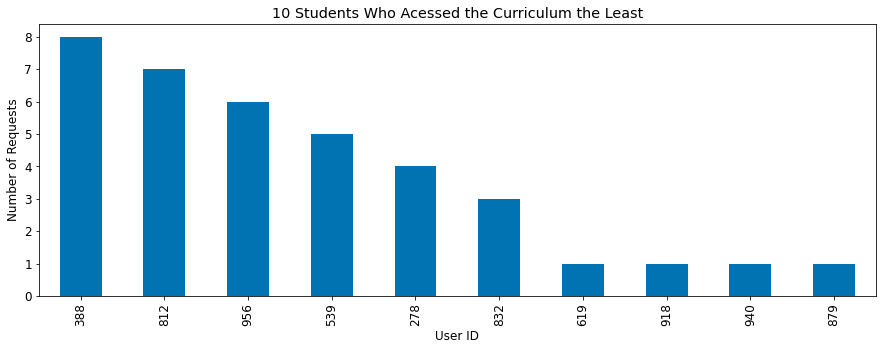

In [90]:
# plot it
active_df.user_id.value_counts().tail(10).plot.bar(figsize=(15,5))
plt.title('10 Students Who Acessed the Curriculum the Least')
plt.xlabel('User ID')
plt.ylabel('Number of Requests');

In [91]:
# take a look at whole row for these ten students to get info about them
# active_df[active_df.user_id.isin(low_access_list)]

In [92]:
active_df[active_df.user_id == 879]

,path,user_id,ip,name,start_date,end_date,created_at,updated_at,program,module/lesson
date,,,,,,,,,,
2021-01-26 12:21:18,/,879,136.50.50.187,Marco,2021-01-25,2021-07-19,2021-01-20 21:31:11,2021-01-20 21:31:11,Web Dev - Java,/


In [93]:
low_access_list

[388, 812, 956, 539, 278, 832, 619, 918, 940, 879]

User 388
- Web Dev - Java
- Andromeda
- Looks like they were only in the program for a day

User 812
- Web Dev - Java
- Hyperion
- Looks like they were only in the program for a day

User 956
- Web Dev - Java
- Oberon
- Looks like they were only in the program for a few days

User 539
- Web Dev - Java
- Europa
- Looks like they were only in the program for a day

User 278
- Web Dev - Java
- Voyageurs
- Looks like they were only in the program for a day

User 832
- Web Dev - Java
- Jupiter
- Looks like they were only in the program for a day

User 619
- Web Dev - Java
- Ganymede
- Looks like they were only in the program for a day

User 918
- Web Dev - Java
- Neptune
- Looks like they were only in the program for a day

User 940
- Web Dev - Java
- Neptune
- Looks like they were only in the program for a day

User 879
- Web Dev - Java
- Marco
- Looks like they were only in the program for a day

4. Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?

Refer to Madeleine's notebook to identify users with unusually high number of requests or high number of unique requests

5. At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?

Try to identify exact date when this happened? Somehow identify paths as being in ds or webdev and then find counts of requests by program for pages outside of their program

### 6.

6. What topics are grads continuing to reference after graduation and into their jobs (for each program)?

Take subset of post graduation requets given program and unstack

In [94]:
post_grad_df = df1[(df1.index > df1.end_date)]
post_grad_df

,path,user_id,ip,name,start_date,end_date,created_at,updated_at,program,module/lesson
date,,,,,,,,,,
2018-01-26 09:56:02,java-ii,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,Web Dev - PHP,NaN
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,Web Dev - PHP,java-ii/object-oriented-programming
2018-01-26 09:56:06,slides/object_oriented_programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,Web Dev - PHP,slides/object_oriented_programming
2018-01-26 10:14:51,javascript-i,11,97.105.19.61,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,Web Dev - PHP,NaN
2018-01-26 10:15:02,javascript-i/functions,11,97.105.19.61,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,Web Dev - PHP,javascript-i/functions
...,...,...,...,...,...,...,...,...,...,...
2021-04-21 16:41:51,jquery/personal-site,64,71.150.217.33,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,Web Dev - Java,jquery/personal-site
2021-04-21 16:42:02,jquery/mapbox-api,64,71.150.217.33,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,Web Dev - Java,jquery/mapbox-api
2021-04-21 16:42:09,jquery/ajax/weather-map,64,71.150.217.33,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,Web Dev - Java,jquery/ajax


In [95]:
post_grad_df.program.value_counts()

Web Dev - Java         137357
Web Dev - PHP           28708
Data Science             8108
Web Dev - Front End         4
Name: program, dtype: int64

In [96]:
# post_grad_df.groupby('program').path.value_counts().head(20)

#### All programs

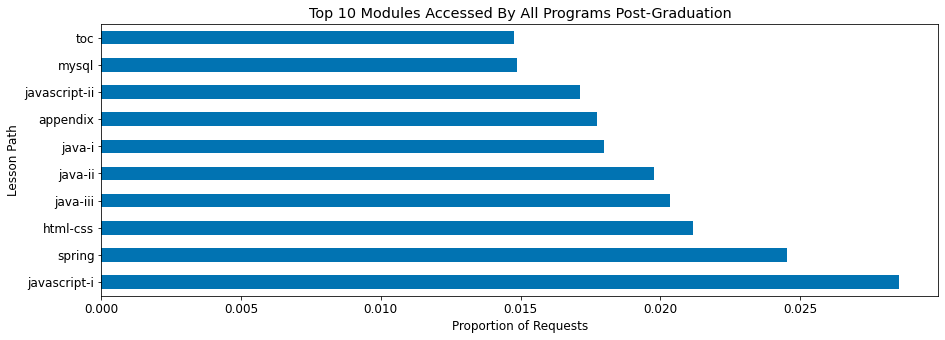

In [97]:
post_grad_df.path.value_counts(normalize=True).head(10).plot.barh(figsize=(15,5))
plt.title('Top 10 Modules Accessed By All Programs Post-Graduation')
plt.ylabel('Lesson Path')
plt.xlabel('Proportion of Requests');

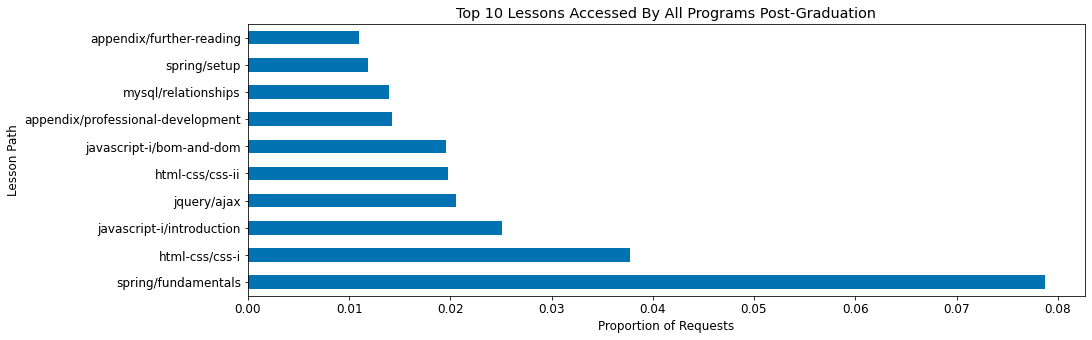

In [98]:
post_grad_df['module/lesson'].value_counts(normalize=True).head(10).plot.barh(figsize=(15,5))
plt.title('Top 10 Lessons Accessed By All Programs Post-Graduation')
plt.ylabel('Lesson Path')
plt.xlabel('Proportion of Requests');

#### PHP

In [99]:
pg_php = post_grad_df[post_grad_df.program == 'Web Dev - PHP']

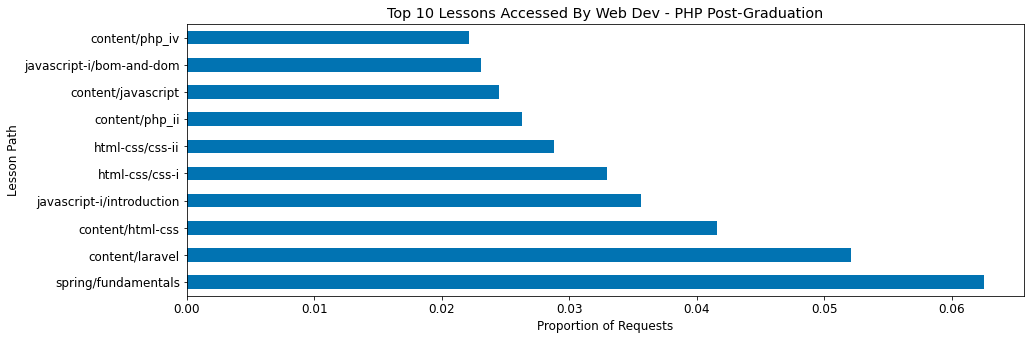

In [100]:
pg_php['module/lesson'].value_counts(normalize=True).head(10).plot.barh(figsize=(15,5))
plt.title('Top 10 Lessons Accessed By Web Dev - PHP Post-Graduation')
plt.ylabel('Lesson Path')
plt.xlabel('Proportion of Requests');

In [101]:
# pg_php.path.value_counts(normalize=True).head(10).plot.barh(figsize=(15,5))
# plt.title('Top 10 Paths Accessed By Web Dev - PHP Post-Graduation')
# plt.ylabel('Lesson Path')
# plt.xlabel('Proportion of Requests');

#### Java

In [102]:
pg_java = post_grad_df[post_grad_df.program == 'Web Dev - Java']

In [103]:
# pg_java.path.value_counts(normalize=True).head(10).plot.barh(figsize=(15,5))
# plt.title('Top 10 Lessons Accessed By Web Dev - Java Post-Graduation')
# plt.ylabel('Lesson Path')
# plt.xlabel('Proportion of Requests');

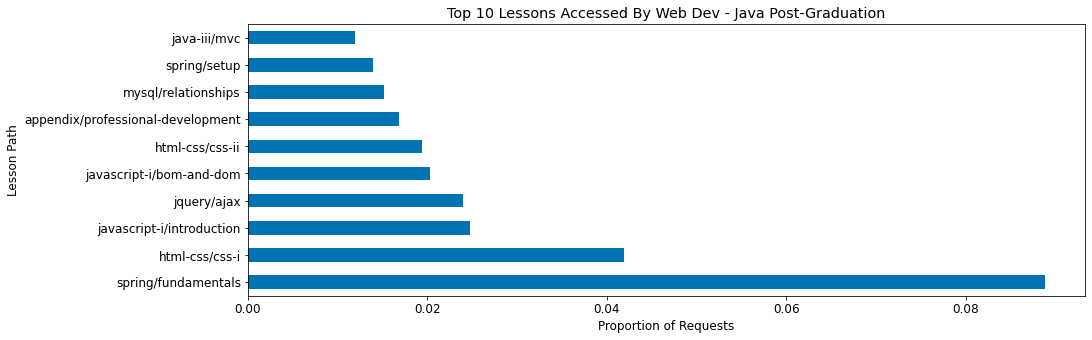

In [104]:
pg_java['module/lesson'].value_counts(normalize=True).head(10).plot.barh(figsize=(15,5))
plt.title('Top 10 Lessons Accessed By Web Dev - Java Post-Graduation')
plt.ylabel('Lesson Path')
plt.xlabel('Proportion of Requests');

#### DS

In [105]:
pg_ds = post_grad_df[post_grad_df.program == 'Data Science']

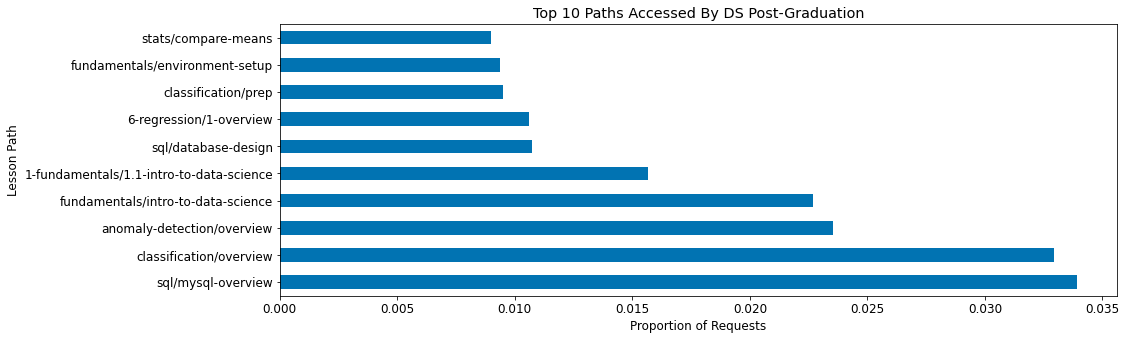

In [106]:
pg_ds.path.value_counts(normalize=True).head(10).plot.barh(figsize=(15,5))
plt.title('Top 10 Paths Accessed By DS Post-Graduation')
plt.ylabel('Lesson Path')
plt.xlabel('Proportion of Requests');

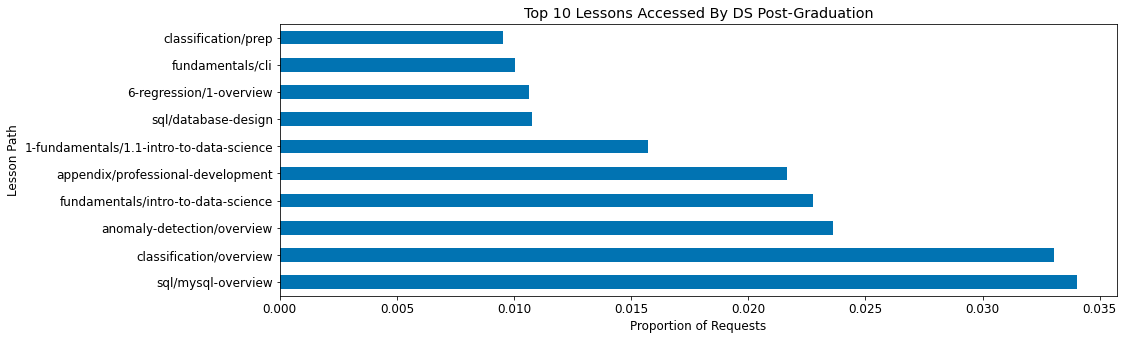

In [107]:
pg_ds['module/lesson'].value_counts(normalize=True).head(10).plot.barh(figsize=(15,5))
plt.title('Top 10 Lessons Accessed By DS Post-Graduation')
plt.ylabel('Lesson Path')
plt.xlabel('Proportion of Requests');

### 7.

7. Which lessons are least accessed?

#### All Programs

In [108]:
# low_all = df1['module/lesson'].value_counts()
# low_all[low_all.values > 0].tail(10).plot.barh(figsize=(15,5))
# plt.title('Bottom 10 Lessons Accessed Across All Programs')
# plt.ylabel('Lesson Path')
# plt.xlabel('Number of Requests');

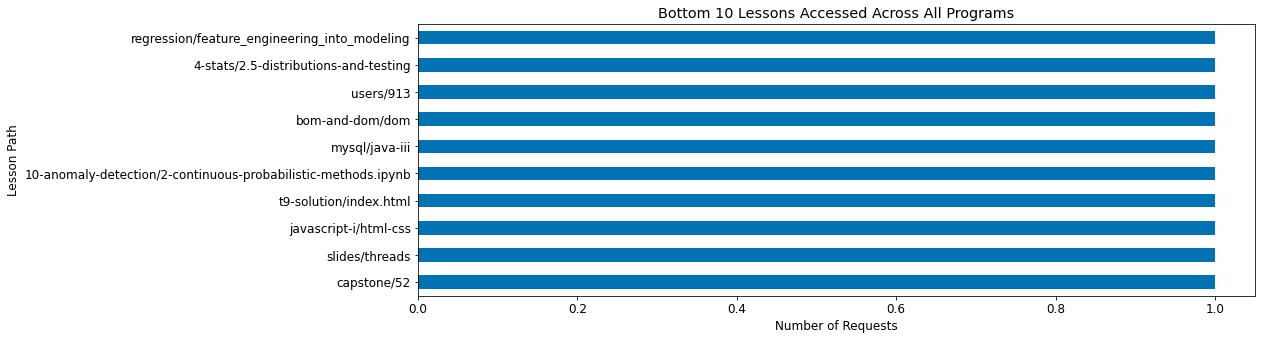

In [109]:
df1 = df1[~df1.path.str.endswith('png)')]
df1['module/lesson'].value_counts().tail(10).plot.barh(figsize=(15,5))
plt.title('Bottom 10 Lessons Accessed Across All Programs')
plt.ylabel('Lesson Path')
plt.xlabel('Number of Requests');

In [110]:
# df1.path.value_counts(normalize=True).tail(10).plot.barh(figsize=(15,5))
# plt.title('Bottom 10 Paths Accessed Across All Programs')
# plt.ylabel('Module')
# plt.xlabel('Proportion of Requests');

#### PHP

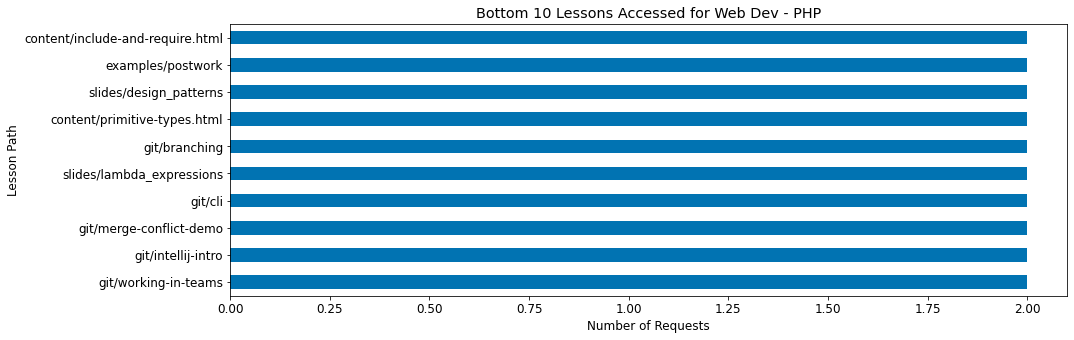

In [111]:
low_php = php_df['module/lesson'].value_counts()
low_php[low_php.values > 1].tail(10).plot.barh(figsize=(15,5))
plt.title('Bottom 10 Lessons Accessed for Web Dev - PHP')
plt.ylabel('Lesson Path')
plt.xlabel('Number of Requests');

In [112]:
# php_df.path.value_counts(normalize=True).tail(10).plot.barh(figsize=(15,5))
# plt.title('Bottom 10 Modules Accessed for Web Dev - PHP')
# plt.xlabel('Module')
# plt.ylabel('Proportion of Requests');

#### Java

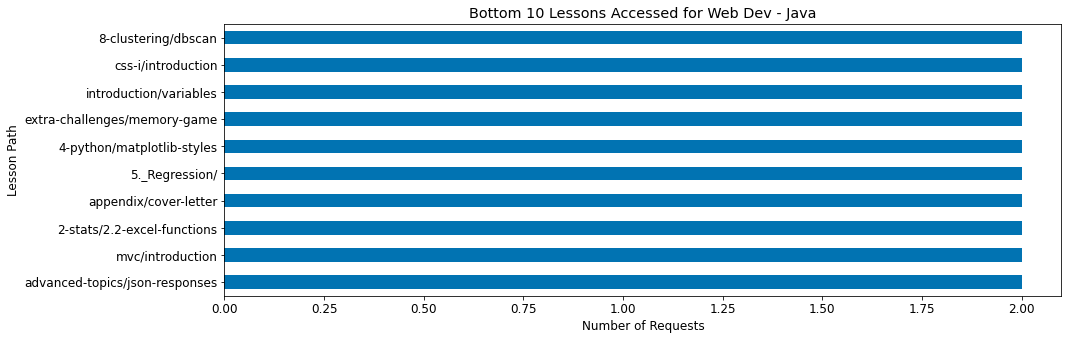

In [113]:
low_java = java_df['module/lesson'].value_counts()
low_java[low_java.values > 1].tail(10).plot.barh(figsize=(15,5))
plt.title('Bottom 10 Lessons Accessed for Web Dev - Java')
plt.ylabel('Lesson Path')
plt.xlabel('Number of Requests');

In [114]:
# java_df.path.value_counts(normalize=True).tail(10).plot.barh(figsize=(15,5))
# plt.title('Bottom 10 Modules Accessed for Web Dev - Java')
# plt.xlabel('Module')
# plt.ylabel('Proportion of Requests');

#### Front End

In [115]:
# fe_df['module/lesson'].value_counts(normalize=True).tail(10).plot.bar(figsize=(15,5))
# plt.title('Bottom Lessons Accessed for Web Dev - Front End')
# plt.xlabel('Lesson Path')
# plt.ylabel('Proportion of Requests');

**Not really useful, will not include in email since this program had so few students**

In [116]:
fe_df.shape

(4, 10)

In [117]:
# fe_df.path.value_counts(normalize=True).tail(10).plot.bar(figsize=(15,5))
# plt.title('Bottom 3 Paths Accessed for Web Dev - Front End')
# plt.xlabel('Lesson Path')
# plt.ylabel('Proportion of Requests');

#### Data Science

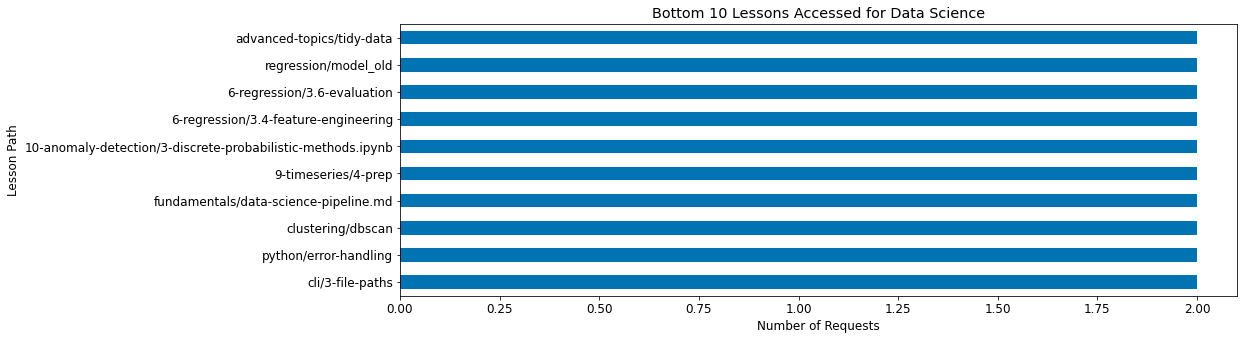

In [118]:
ds_df = ds_df[~ds_df.path.str.endswith('png)')]
low_ds = ds_df['module/lesson'].value_counts()
low_ds[low_ds.values > 1].tail(10).plot.barh(figsize=(15,5))
plt.title('Bottom 10 Lessons Accessed for Data Science')
plt.ylabel('Lesson Path')
plt.xlabel('Number of Requests');

In [119]:
# ds_df.path.value_counts(normalize=True).tail(10).plot.bar(figsize=(15,5))
# plt.title('Bottom 10 Paths Accessed for Data Science')
# plt.xlabel('Lesson Path')
# plt.ylabel('Proportion of Requests');

8. Anything else I should be aware of?

Take a look at converting to time series data by aggregating and using Bollinger Bands